# Time Series Clustering with K-Means and Euclidean Distance Matrix for total (n2) with Engineered Features from different distance metrics


This notebook provides a clustering for the total (n2) column of the acceleration data of all trips. The exact approach can be seen here.

----
**Specification of experiment:**
- scripted and ordinary trips
- n2 column of acceleration data was used
- Euclidean/cosine/correlation Distance was calculated and combined during the feature engineering
- Feature Engineering with Quantiles, Standard deviation of the different distance metrics, after that PCA was used for decorrelation

-----
**Results:**

1) KMeans Clustering:

    Estimated number of clusters: 5

    True number of clusters: 3

    Homogeneity: 0.297

    Completeness: 0.424

    V-measure: 0.349

    Adjusted MI: 0.296

    Silhouette Coefficient: 0.441






*Assume that transport modes are true clusters

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets
from visualization.visualize import get_distribution_of_cluster_labels_for
from visualization.visualize import plot_all_trips_with_cluster_coloring

%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels

%aimport models.cluster
from models.cluster import get_clustering_performance

In [2]:
# Set to true if all trips should be plotted at the end
plot_all_trips = True

data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

In [3]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]


euclidean_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="euclidean")
correlation_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="correlation")
cosine_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="cosine")

--------------
# Feature Engineering

## Summary Statistics of euclidean distances:

In [4]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_only = euclidean_distances.drop(categorical_columns,axis=1)


In [5]:
percentiles=[0.1*(i+1) for i in range(10)]
summaries_euclidean = trips_only.transpose().describe(percentiles=percentiles).T
summaries_euclidean = summaries_euclidean.drop(["count","min","max","mean"],axis=1)
summaries_euclidean.head()

std       10%        20%      30.0%        40%        50%      60.0%  \
0  45.255349  5.675635  11.113760  13.093744  15.599651  17.183467  23.271248   
1  45.281317  6.484982   9.926178  11.847983  14.103340  15.543058  22.027685   
2  45.474589  5.230508   9.936757  11.916160  14.359573  15.877138  22.052211   
3  45.689249  5.953875   8.036921  10.039480  12.258101  14.029167  20.432647   
4  45.450826  6.971805   8.609343  10.250522  12.330651  14.005442  20.325829   

         70%         80%         90%        100%  
0  63.795109  101.100483  116.479803  168.729605  
1  63.391946  100.335403  115.901902  167.822824  
2  63.372579  100.459934  116.129906  167.915836  
3  63.205943   99.708979  115.479392  166.760233  
4  62.893785   99.580703  115.399815  166.822958

## Summary Statistics of correlation distances:

In [6]:
summaries_corr = correlation_distances.drop(categorical_columns,axis=1).transpose().describe(percentiles=percentiles).T
summaries_corr = summaries_corr.drop(["count","min","max","mean"],axis=1)
summaries_corr.head()

std       10%       20%     30.0%       40%       50%     60.0%  \
0  0.141535  0.853489  0.936438  0.971939  0.989916  1.004573  1.018098   
1  0.087695  0.901101  0.941065  0.963561  0.983394  0.999337  1.014803   
2  0.094606  0.902517  0.939594  0.966875  0.984759  1.001292  1.021783   
3  0.158949  0.833304  0.918702  0.961199  0.983728  1.002422  1.023896   
4  0.076070  0.917919  0.949691  0.969082  0.985764  1.000713  1.015585   

        70%       80%       90%      100%  
0  1.038933  1.075721  1.131915  1.546471  
1  1.030689  1.056769  1.098400  1.369148  
2  1.041496  1.066171  1.107791  1.451324  
3  1.046868  1.086301  1.168304  1.767814  
4  1.030405  1.049832  1.087056  1.323634

## Summary Statistics of cosine distances

In [7]:
summaries_cosine = cosine_distances.drop(categorical_columns,axis=1).transpose().describe(percentiles=percentiles).T
summaries_cosine = summaries_cosine.drop(["count","min","max","mean"],axis=1)
summaries_cosine.head()

std       10%       20%     30.0%       40%       50%     60.0%  \
0  0.033716  0.000052  0.000075  0.000103  0.000159  0.000344  0.002096   
1  0.033725  0.000169  0.000191  0.000223  0.000278  0.000451  0.002273   
2  0.033723  0.000047  0.000068  0.000095  0.000149  0.000329  0.002042   
3  0.033711  0.000067  0.000091  0.000120  0.000176  0.000361  0.002121   
4  0.033725  0.000184  0.000205  0.000233  0.000293  0.000463  0.002217   

        70%       80%       90%      100%  
0  0.026862  0.060719  0.080246  0.112580  
1  0.027494  0.061020  0.080629  0.114187  
2  0.027008  0.060600  0.080355  0.112795  
3  0.026971  0.060677  0.080215  0.112340  
4  0.027337  0.060813  0.080718  0.112961

## Use Correlation distance, cosine distance and euclidean distance summary features together

In [8]:
summaries = deepcopy(summaries_euclidean)
for name in summaries_euclidean.columns:
    summaries["cor_"+name] = summaries_corr[name]
    summaries["cosine_"+name]=summaries_cosine[name]
summaries.head()

std       10%        20%      30.0%        40%        50%      60.0%  \
0  45.255349  5.675635  11.113760  13.093744  15.599651  17.183467  23.271248   
1  45.281317  6.484982   9.926178  11.847983  14.103340  15.543058  22.027685   
2  45.474589  5.230508   9.936757  11.916160  14.359573  15.877138  22.052211   
3  45.689249  5.953875   8.036921  10.039480  12.258101  14.029167  20.432647   
4  45.450826  6.971805   8.609343  10.250522  12.330651  14.005442  20.325829   

         70%         80%         90%     ...       cor_60.0%  cosine_60.0%  \
0  63.795109  101.100483  116.479803     ...        1.018098      0.002096   
1  63.391946  100.335403  115.901902     ...        1.014803      0.002273   
2  63.372579  100.459934  116.129906     ...        1.021783      0.002042   
3  63.205943   99.708979  115.479392     ...        1.023896      0.002121   
4  62.893785   99.580703  115.399815     ...        1.015585      0.002217   

    cor_70%  cosine_70%   cor_80%  cosine_80%   cor_90%  cosine_90%  cor_100%  \
0  1.038933    0.026862  1.075721    0.060719  1.131915    0.080246  1.546471   
1  1.030689    0.027494  1.056769    0.061020  1.098400    0.080629  1.369148   
2  1.041496    0.027008  1.066171    0.060600  1.107791    0.080355  1.451324   
3  1.046868    0.026971  1.086301    0.060677  1.168304    0.080215  1.767814   
4  1.030405    0.027337  1.049832    0.060813  1.087056    0.080718  1.323634   

   cosine_100%  
0     0.112580  
1     0.114187  
2     0.112795  
3     0.112340  
4     0.112961  

[5 rows x 33 columns]

In [9]:
from sklearn.preprocessing import scale

summaries_scaled = pd.DataFrame(scale(summaries),columns=summaries.columns)
summaries_scaled.head()

std       10%       20%     30.0%       40%       50%     60.0%  \
0  0.762991 -0.716578 -0.637763 -0.623615 -0.616939 -0.655671 -0.640325   
1  0.765357 -0.699089 -0.663807 -0.651187 -0.650687 -0.693511 -0.670153   
2  0.782965 -0.726197 -0.663575 -0.649678 -0.644908 -0.685805 -0.669564   
3  0.802521 -0.710566 -0.705240 -0.691214 -0.692304 -0.728433 -0.708410   
4  0.780800 -0.688569 -0.692687 -0.686543 -0.690668 -0.728981 -0.710972   

        70%       80%       90%     ...       cor_60.0%  cosine_60.0%  \
0 -0.596462 -0.515253 -0.524920     ...        2.280412     -0.661655   
1 -0.610707 -0.551572 -0.554165     ...        1.373042     -0.656411   
2 -0.611391 -0.545660 -0.542627     ...        3.295056     -0.663275   
3 -0.617278 -0.581308 -0.575546     ...        3.876901     -0.660912   
4 -0.628307 -0.587398 -0.579573     ...        1.588331     -0.658061   

    cor_70%  cosine_70%   cor_80%  cosine_80%   cor_90%  cosine_90%  cor_100%  \
0  2.481962   -0.666799  2.782729   -0.664743  1.948710   -0.666803  1.620805   
1  1.291867   -0.647237  1.271079   -0.654946  0.736697   -0.654609  0.250437   
2  2.851847   -0.662276  2.020970   -0.668622  1.076305   -0.663348  0.885499   
3  3.627298   -0.663419  3.626656   -0.666100  3.264676   -0.667815  3.331350   
4  1.250814   -0.652095  0.717729   -0.661692  0.326441   -0.651770 -0.101294   

   cosine_100%  
0    -0.648480  
1    -0.612368  
2    -0.643658  
3    -0.653875  
4    -0.639925  

[5 rows x 33 columns]

## Apply PCA  to summaries to get decorrelated features

In [95]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
summaries_reduced = pd.DataFrame(pca.fit_transform(summaries_scaled))

features_used = summaries_reduced
print("Explained Variance Ratio: {}".format(pca.explained_variance_ratio_))

Explained Variance Ratio: [ 0.70899788  0.17154556  0.05284796  0.04375572]


------
## Create Base Model with KMeans Clustering

Use summaries of each distance

In [90]:
from sklearn.cluster import KMeans
random_state = 0

kmeans = KMeans(n_clusters=3, random_state=random_state).fit(features_used)
cluster_labels = kmeans.labels_
euclidean_distances["cluster_labels"]=cluster_labels

## Visualise Clustering on 2D - TSNE Plot:

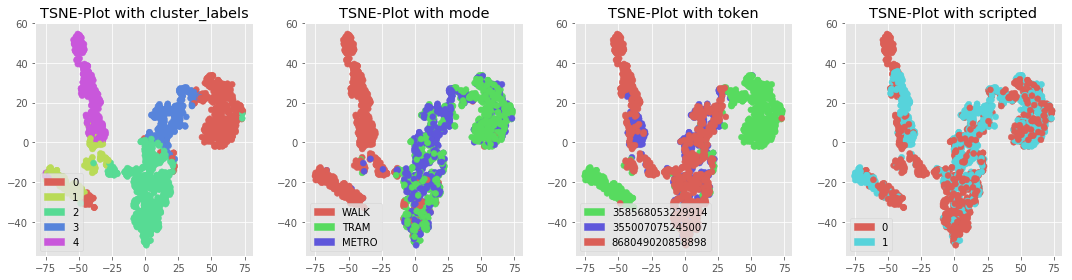

In [96]:
color_encodings = euclidean_distances.loc[:,["cluster_labels","mode","token","scripted"]]
plot_2D_tsne_with_coloring_per_targets(features_used, color_encodings)

### Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [69]:
cluster_performance = get_clustering_performance(features_used, cluster_labels,
                           true_labels=euclidean_distances["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 5

 - True number of clusters: 3

 - Homogeneity: 0.297

 - Completeness: 0.424

 - V-measure: 0.349

 - Adjusted MI: 0.296

 - Silhouette Coefficient: 0.441

## Visualise clustering result for one specific trip

Select one trip:

In [70]:
selected_trip = 5
small_df_trip = euclidean_distances[euclidean_distances.trip_id == selected_trip]
small_df_trip.head()

distance_0  distance_1  distance_2  distance_3  distance_4  distance_5  \
103  113.959151  113.237760  113.624017  113.060284  112.991381  113.035429   
104  112.139829  111.420248  111.726362  110.937990  111.018318  111.061675   
105  116.379215  115.827600  116.162356  115.459892  115.376596  115.494884   
106  117.738323  117.222487  117.396623  116.639942  116.840193  116.833764   
107  114.690394  114.293029  114.454485  113.610813  113.698914  113.729782   

     distance_6  distance_7  distance_8  distance_9       ...        \
103  112.229122  112.546169  112.552454  112.443241       ...         
104  110.101846  110.496921  110.474658  109.939416       ...         
105  115.119478  114.939158  115.029341  114.394016       ...         
106  116.241916  116.182548  116.204136  115.995247       ...         
107  112.821173  113.074732  113.085860  112.732869       ...         

     distance_1827  distance_1828  distance_1829  distance_1830  mode  \
103     111.191757     111.307210     111.506772     111.132310  WALK   
104     108.972022     109.028355     109.210988     109.718245  WALK   
105     113.652134     113.837190     113.316049     113.183789  WALK   
106     114.562355     115.073444     114.937640     115.479897  WALK   
107     111.595508     111.456449     111.448626     111.847472  WALK   

        notes  scripted            token  trip_id  cluster_labels  
103  scripted         1  355007075245007        5               1  
104  scripted         1  355007075245007        5               1  
105  scripted         1  355007075245007        5               1  
106  scripted         1  355007075245007        5               1  
107  scripted         1  355007075245007        5               1  

[5 rows x 1837 columns]

First, make sure that cut trips and original trips are the same by checking the first values in the total column

In [71]:
trips_cut_per_30_sec[trips_cut_per_30_sec.trip_id == selected_trip].head(1)

snippet_0 snippet_1 snippet_2 snippet_3 snippet_4 snippet_5 snippet_6  \
103   14.1751   14.4321   16.5716    12.784   8.81912   6.02161    4.1676   

    snippet_7 snippet_8 snippet_9   ...   snippet_595 snippet_596 snippet_597  \
103   4.49849   9.06437    22.419   ...       13.8621     11.4552     7.93498   

    snippet_598 snippet_599  mode     notes scripted            token trip_id  
103     7.35003     4.85618  WALK  scripted        1  355007075245007       5  

[1 rows x 605 columns]

In [72]:
trips_unpacked = Preprocessor.unpack_all_trips(dfs)
#trips_unpacked = [trip_i for trip_i in trips_unpacked if "scripted" in str(trip_i["annotation"]["notes"][0]).lower()]

acceleration_data_trip = trips_unpacked[selected_trip]["sensor"]
acceleration_data_trip = deepcopy(acceleration_data_trip[acceleration_data_trip.sensor == "acceleration"])
# Important, because indices are not unique
acceleration_data_trip = acceleration_data_trip.reset_index(drop=True)

acceleration_data_trip.head()

time      total         x          y         z  \
0 2017-12-12 15:44:19.973  14.175124 -0.285985  13.933329  2.591274   
1 2017-12-12 15:44:20.018  14.432075  3.002282  13.870204  2.624601   
2 2017-12-12 15:44:20.068  16.571573  7.334171  14.842432 -0.727459   
3 2017-12-12 15:44:20.118  12.784040  3.683990  12.227089 -0.598481   
4 2017-12-12 15:44:20.168   8.819115  0.451098   7.922455  3.848117   

         sensor  
0  acceleration  
1  acceleration  
2  acceleration  
3  acceleration  
4  acceleration

During the cutting process the last segments which are less than 30 seconds are dropped, thats why we have to drop them in the original dataframe as well:

In [73]:
labels = get_cluster_labels(small_df_trip["cluster_labels"])
diff = acceleration_data_trip.shape[0] - len(labels)
rows_to_be_dropped = acceleration_data_trip.tail(diff).index
acceleration_data_trip = acceleration_data_trip.drop(rows_to_be_dropped)
acceleration_data_trip["cluster_labels"]= labels
acceleration_data_trip.head()

time      total         x          y         z  \
0 2017-12-12 15:44:19.973  14.175124 -0.285985  13.933329  2.591274   
1 2017-12-12 15:44:20.018  14.432075  3.002282  13.870204  2.624601   
2 2017-12-12 15:44:20.068  16.571573  7.334171  14.842432 -0.727459   
3 2017-12-12 15:44:20.118  12.784040  3.683990  12.227089 -0.598481   
4 2017-12-12 15:44:20.168   8.819115  0.451098   7.922455  3.848117   

         sensor  cluster_labels  
0  acceleration               1  
1  acceleration               1  
2  acceleration               1  
3  acceleration               1  
4  acceleration               1

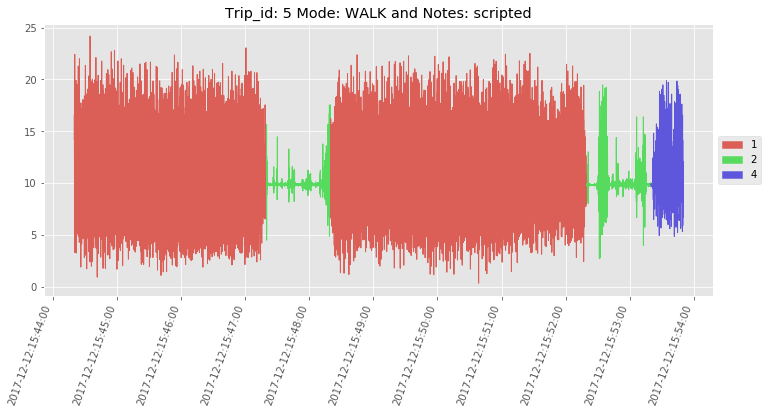

In [74]:
mode = trips_unpacked[selected_trip]["annotation"]["mode"][0]
notes = trips_unpacked[selected_trip]["annotation"]["notes"][0]

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Trip_id: {} Mode: {} and Notes: {}".format(selected_trip, mode,notes))
plot_timeseries_clustering(acceleration_data_trip["time"],acceleration_data_trip["total"], acceleration_data_trip["cluster_labels"], ax=ax)

## Plot the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [75]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", euclidean_distances)
mode_dist_df

count_cluster_0  count_cluster_1  count_cluster_2  count_cluster_3  \
0            171.0              0.0            196.0            105.0   
1              0.0            335.0            100.0             40.0   
2             85.0              0.0            263.0            311.0   

   count_cluster_4   mode  
0              5.0  METRO  
1            218.0   WALK  
2              2.0   TRAM

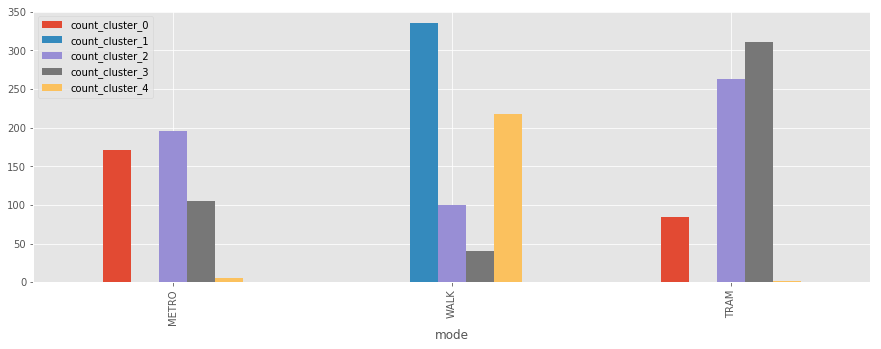

In [76]:
mode_dist_df.set_index("mode").plot(kind="bar",figsize=(15,5));

## Plot distribution of cluster labels for scripted and tokens

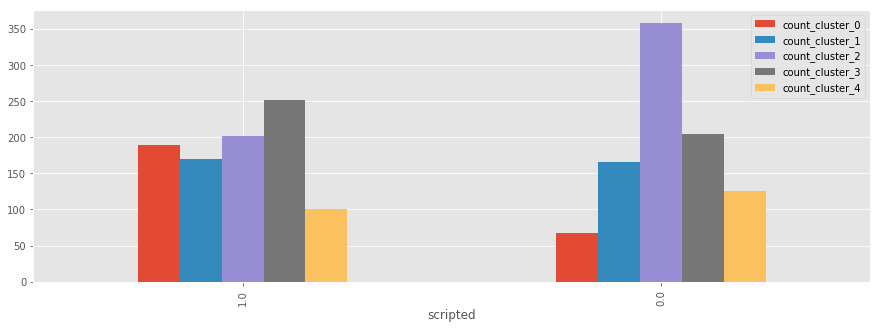

In [77]:
scripted_dist_df = get_distribution_of_cluster_labels_for("scripted", euclidean_distances)
scripted_dist_df.set_index("scripted").plot(kind="bar",figsize=(15,5));

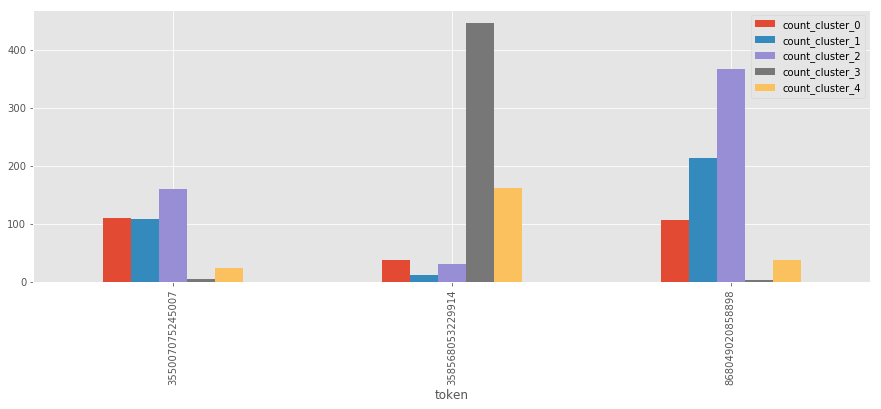

In [78]:
token_dist_df = get_distribution_of_cluster_labels_for("token", euclidean_distances)
token_dist_df.set_index("token").plot(kind="bar",figsize=(15,5));

## Plot all trips with their clustering labels

Produce this plot more conveniently by writing:

C:\Users\Lukas\.conda\envs\Tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



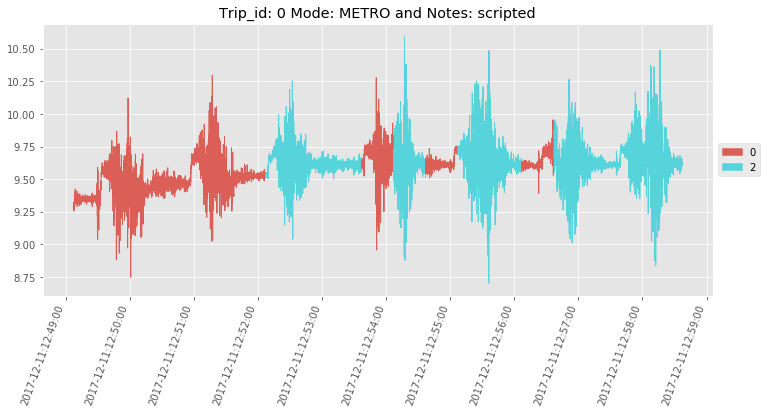

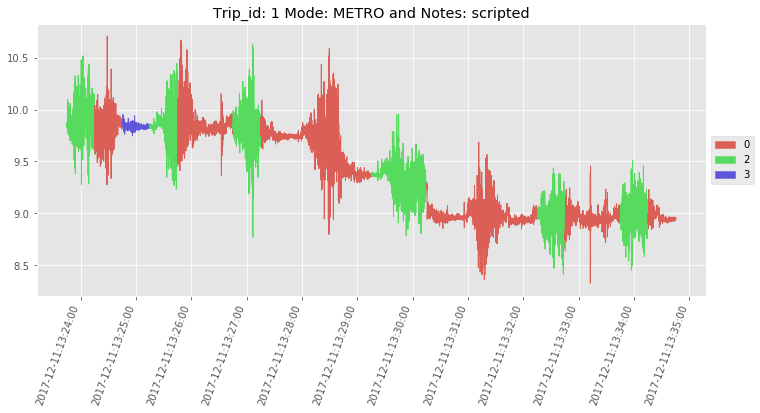

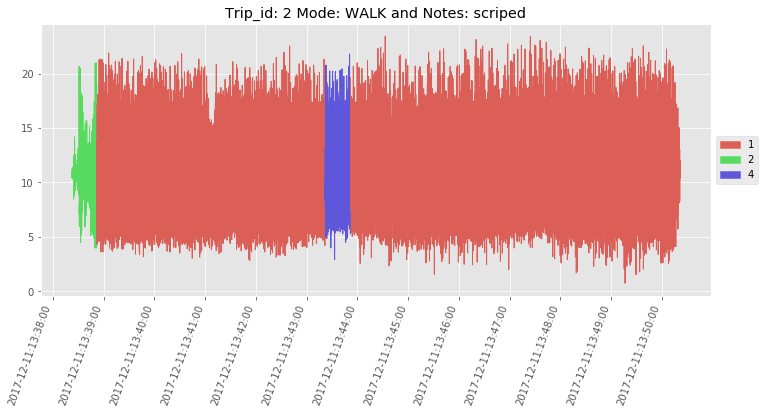

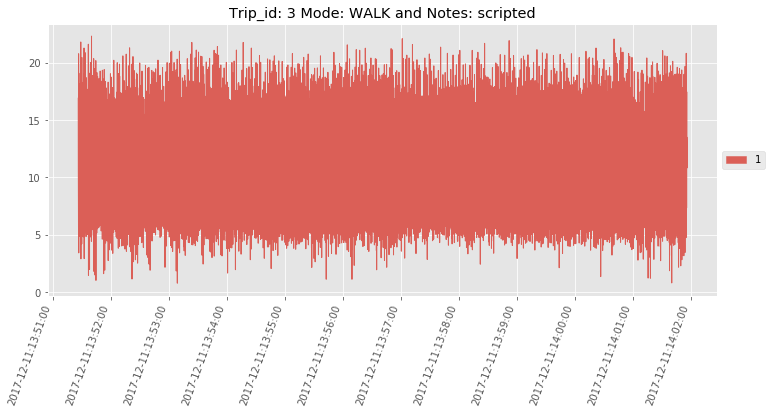

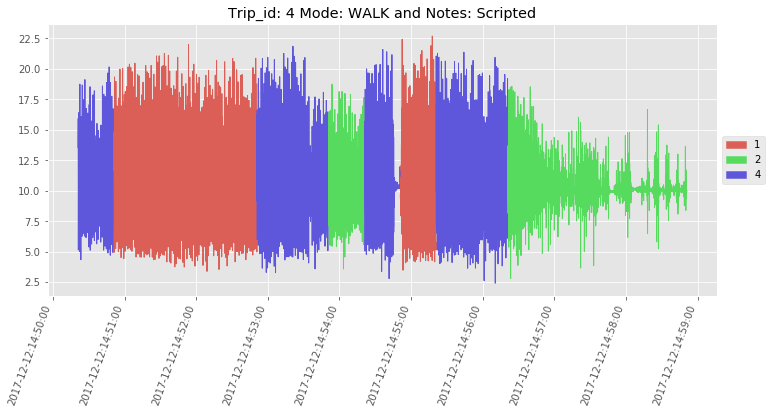

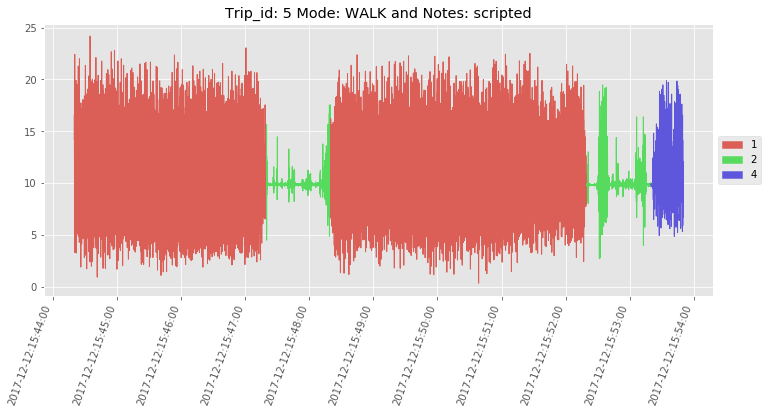

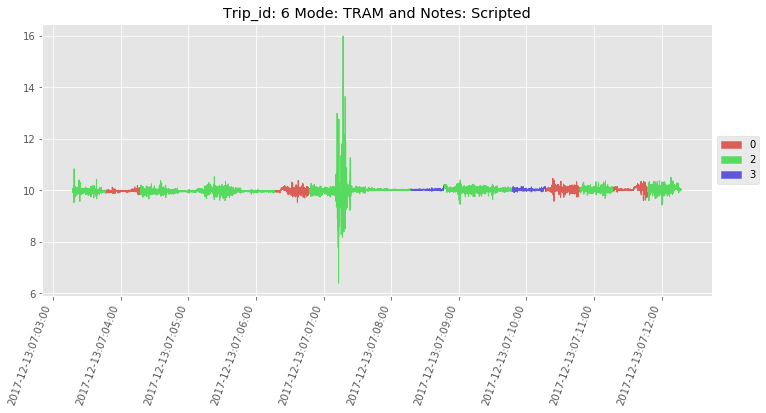

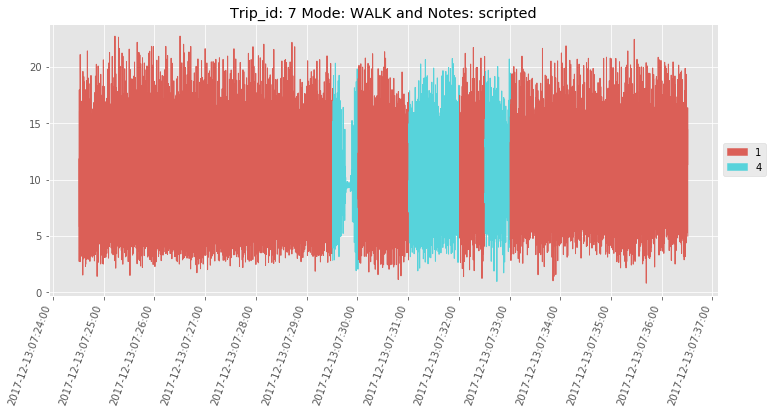

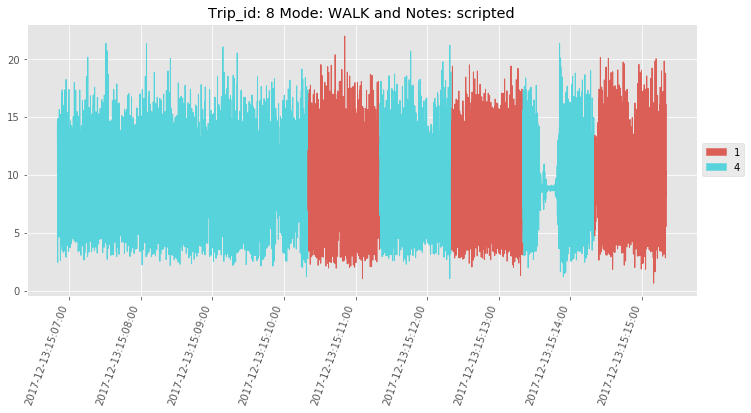

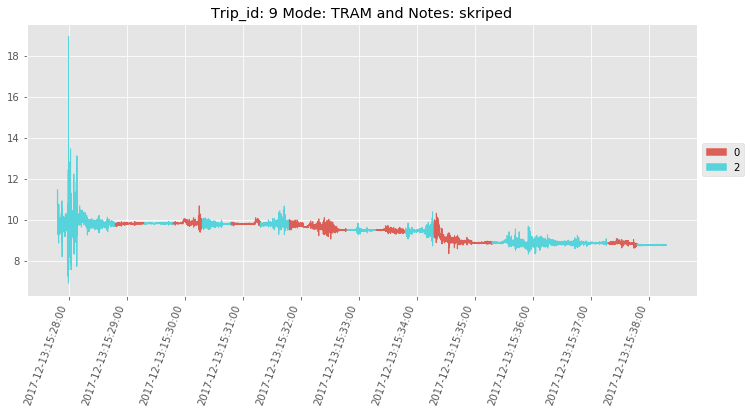

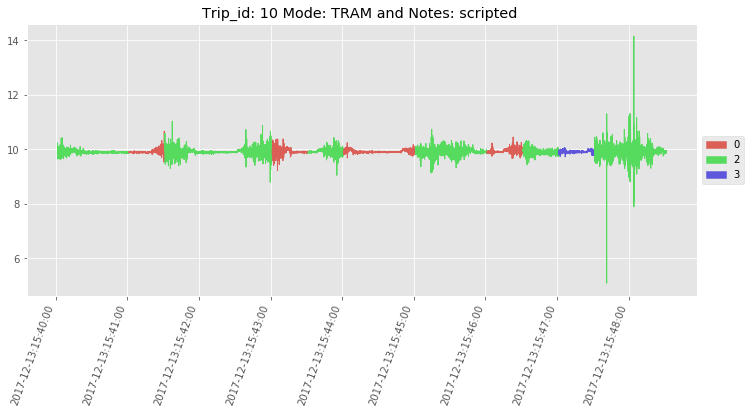

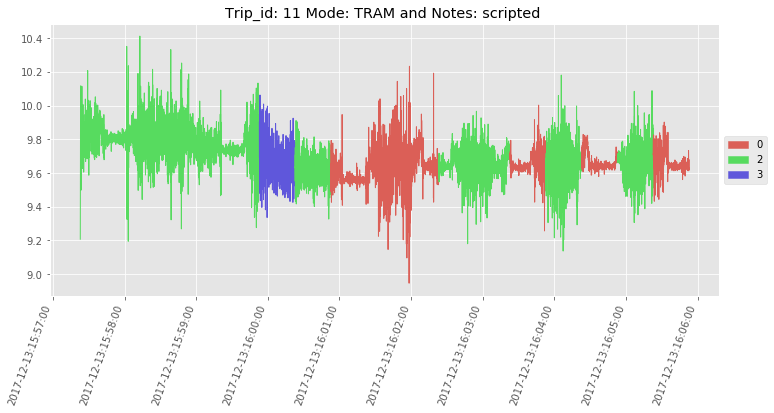

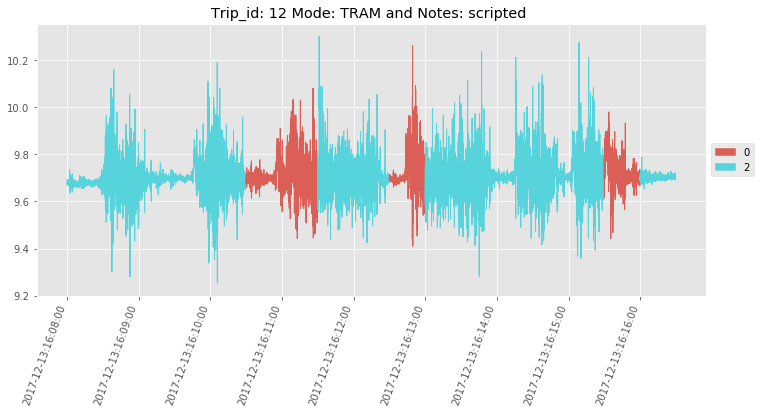

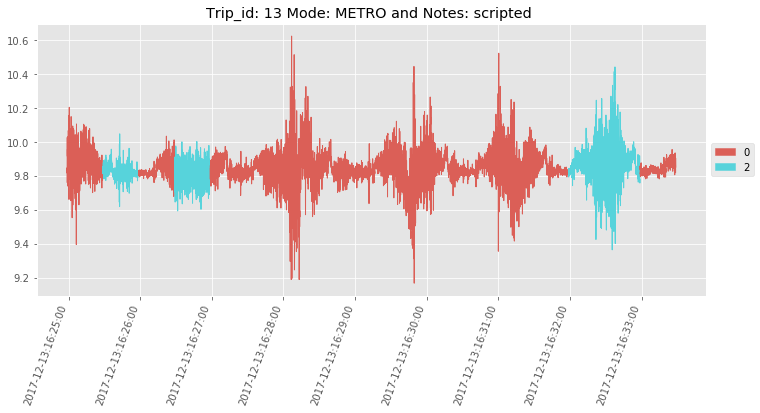

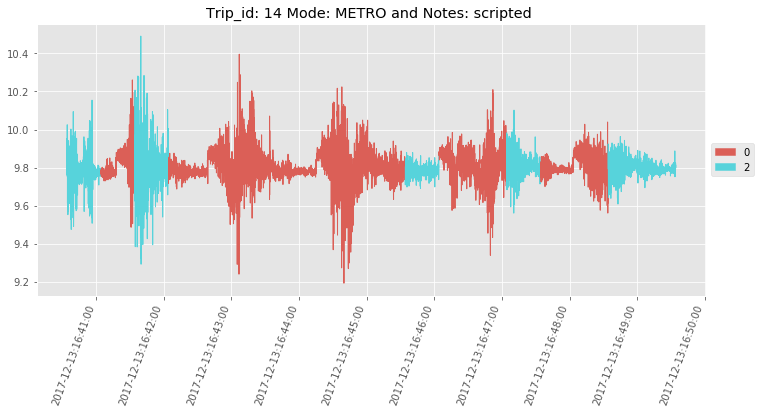

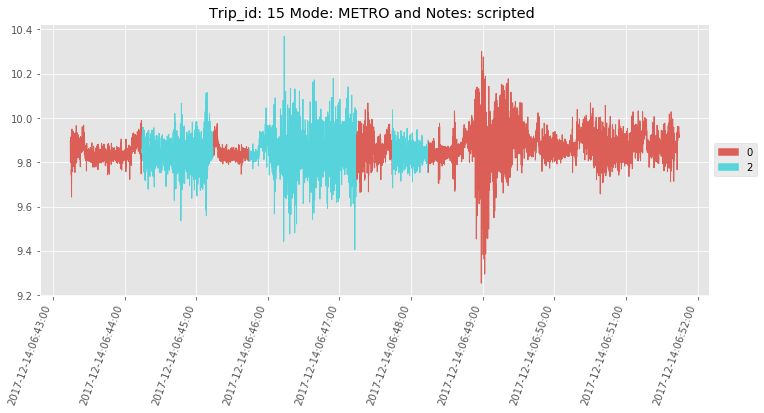

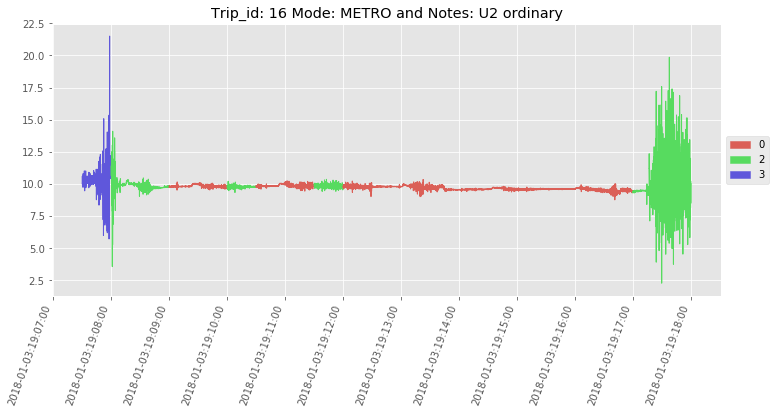

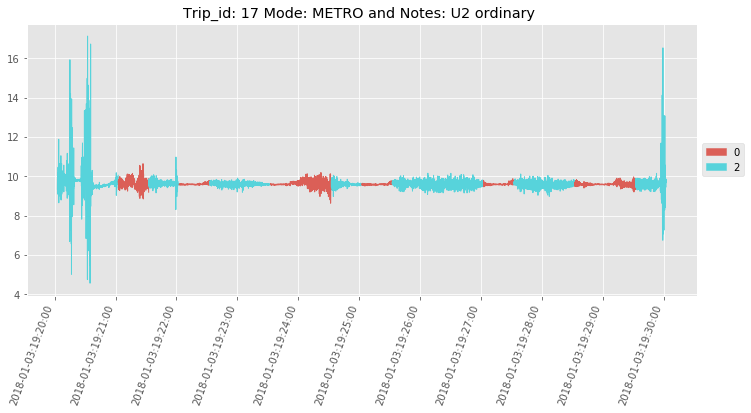

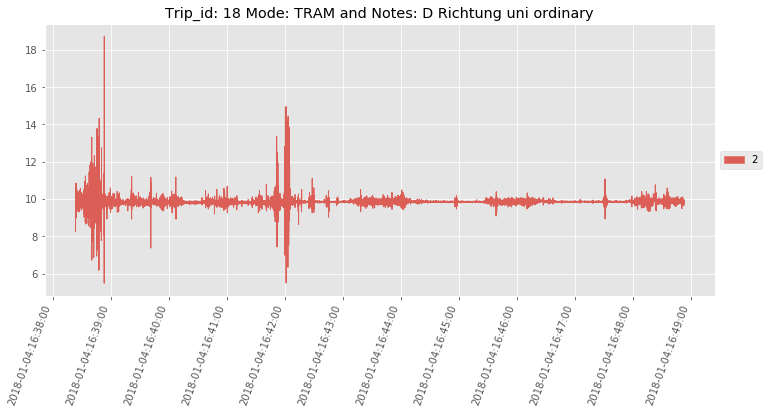

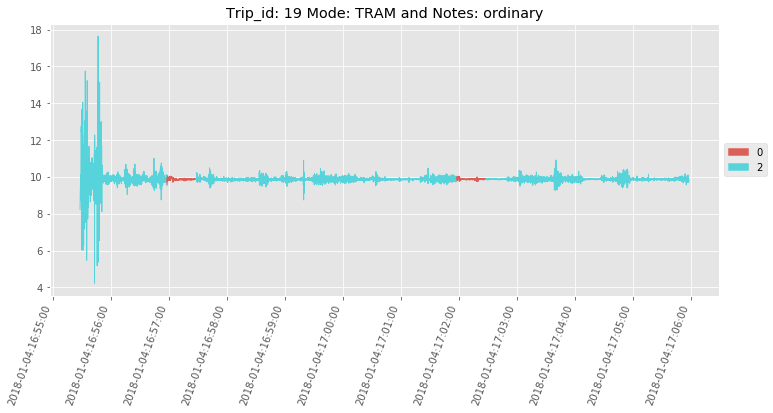

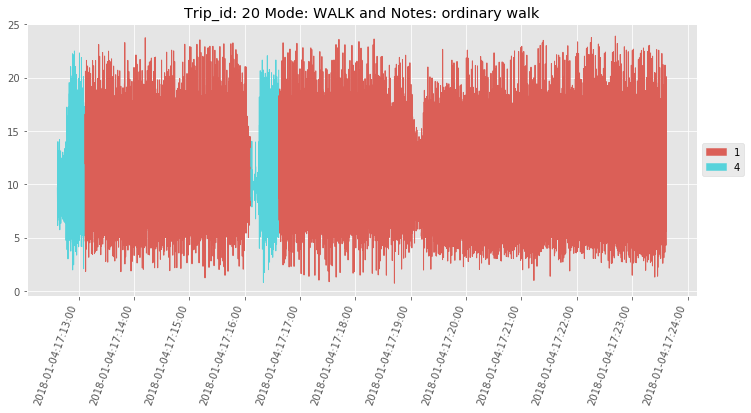

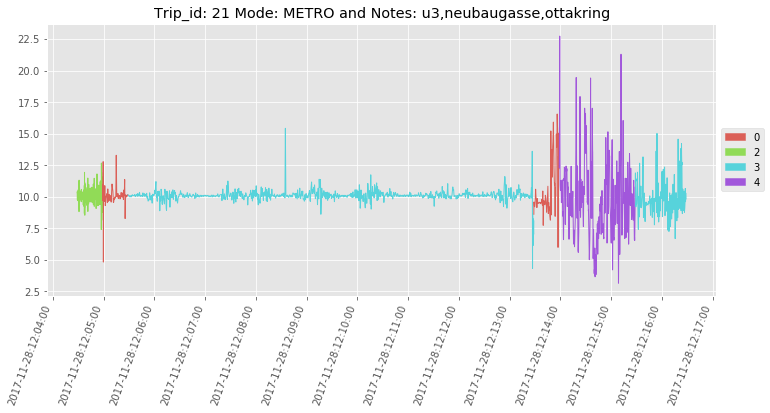

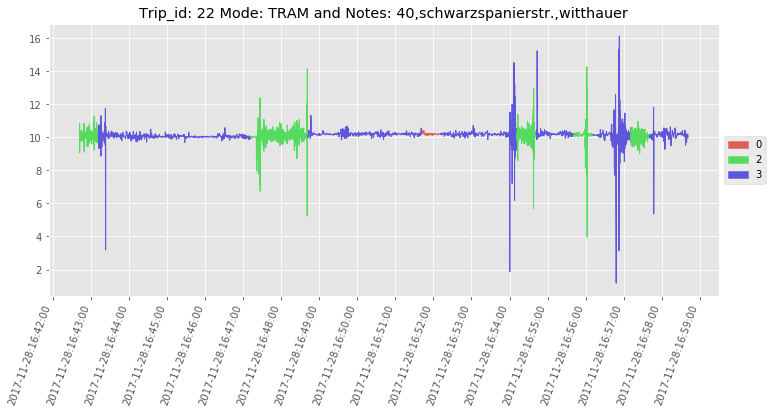

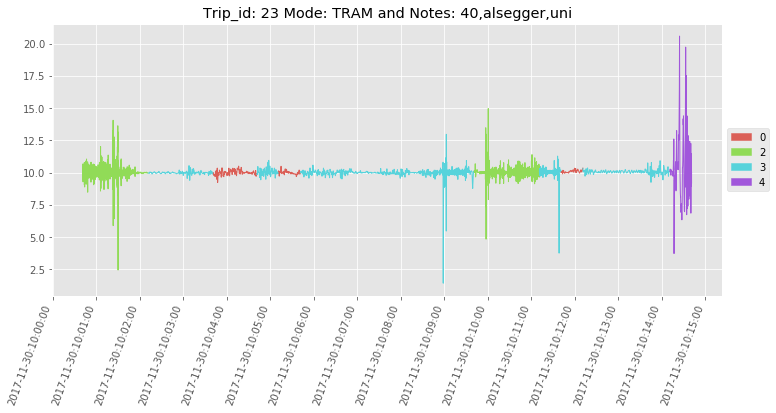

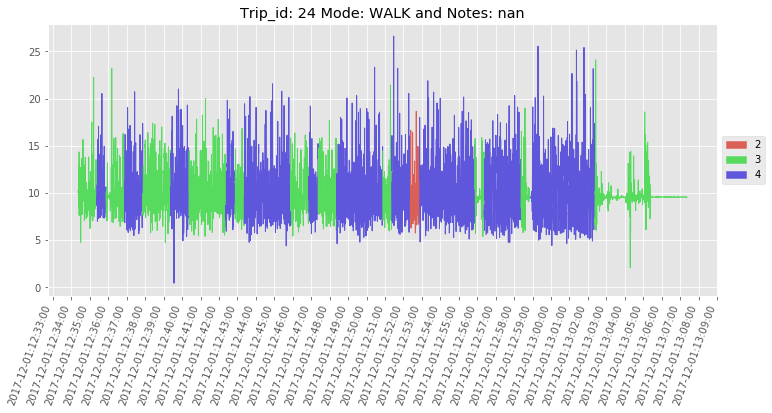

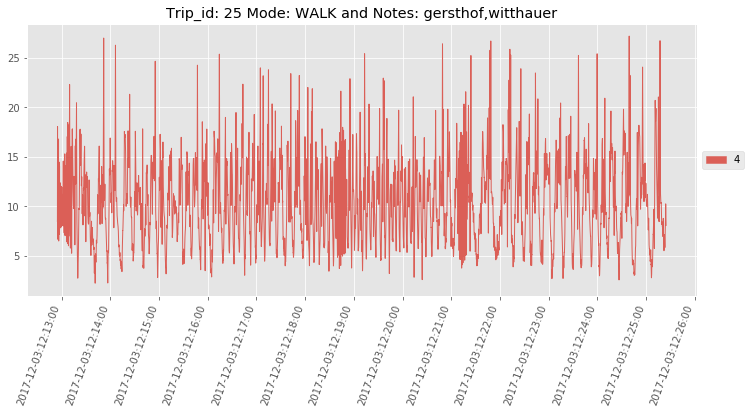

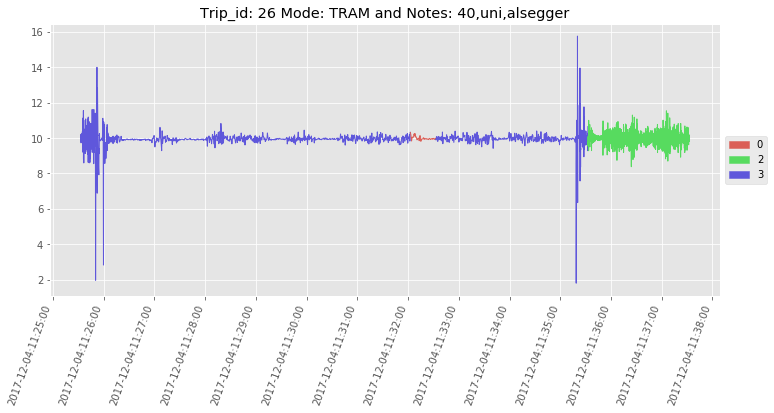

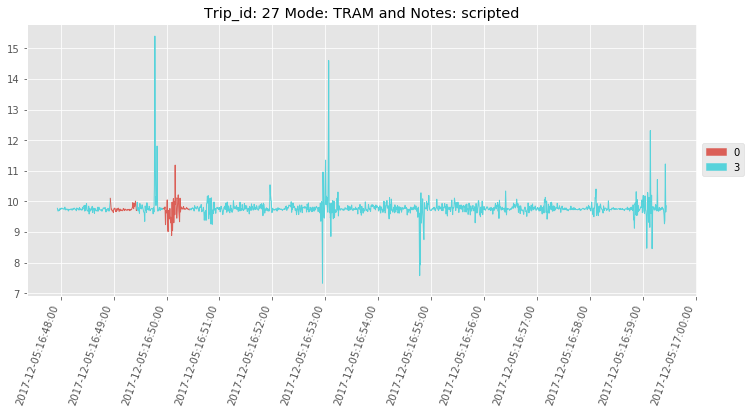

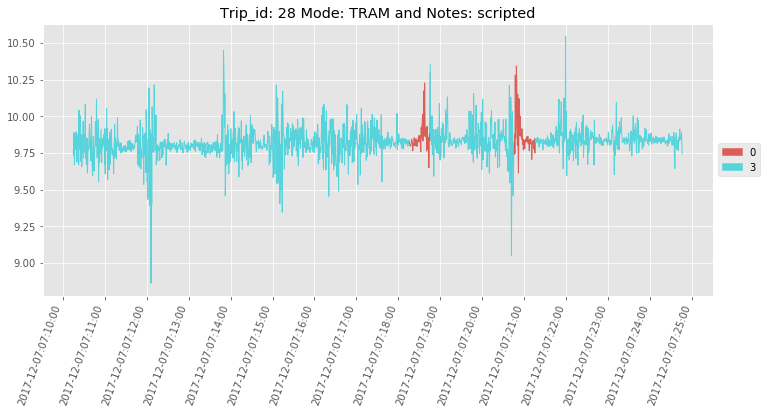

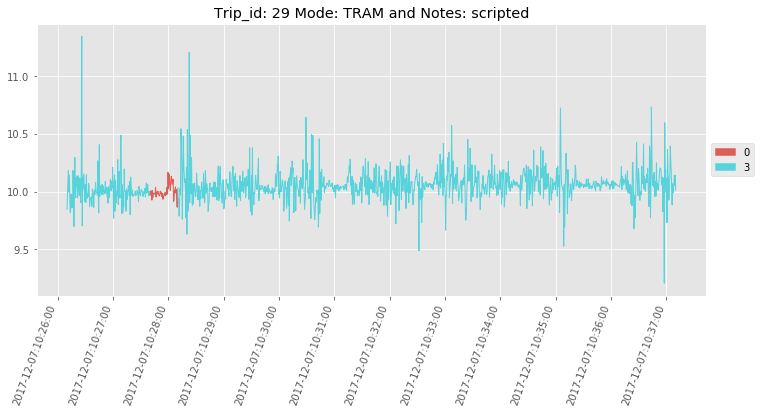

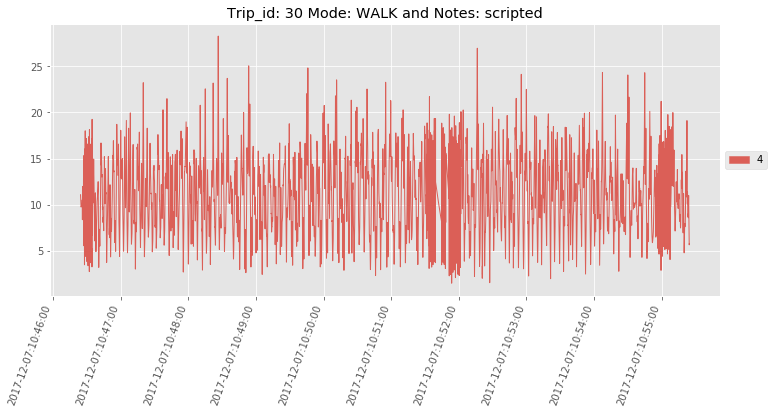

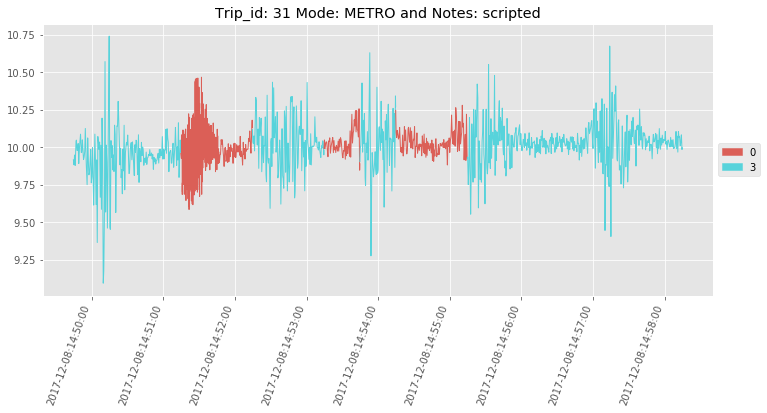

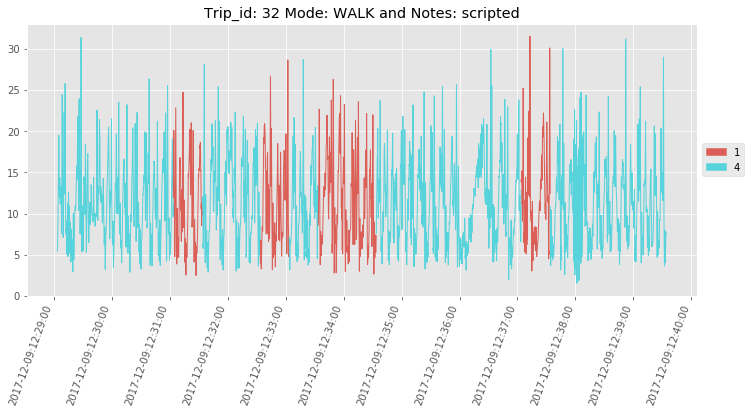

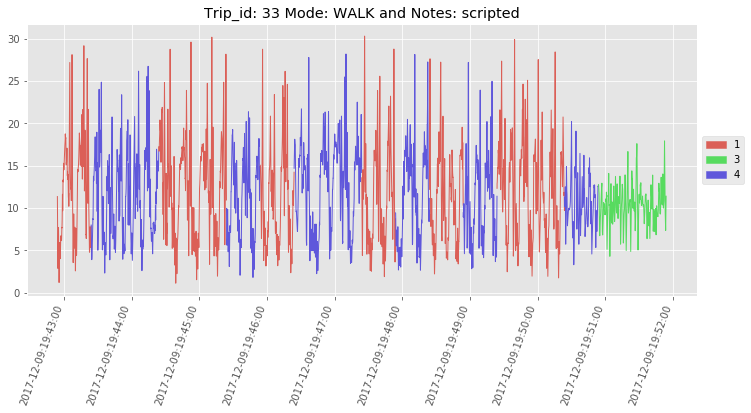

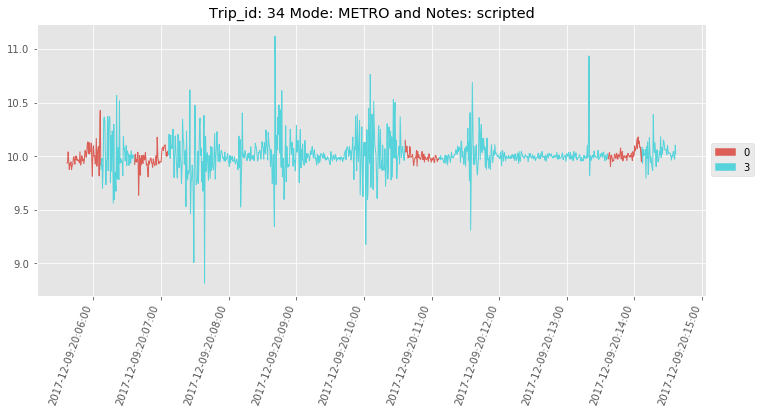

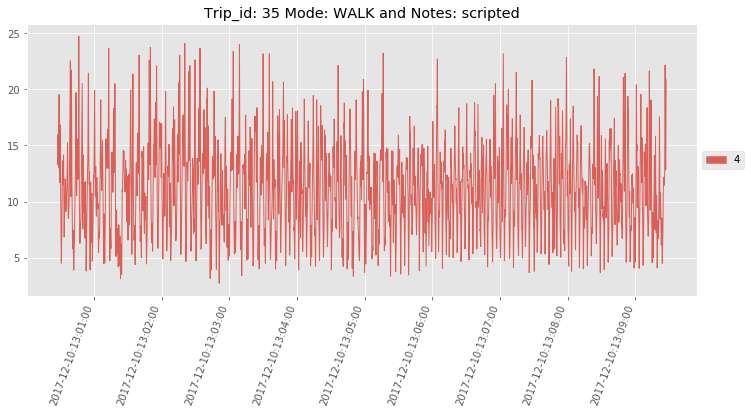

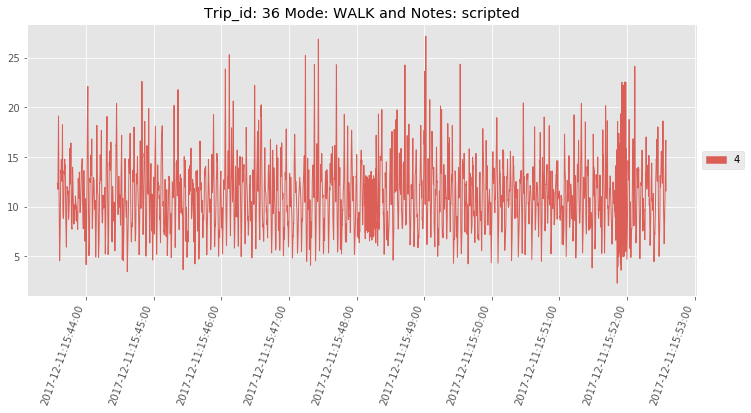

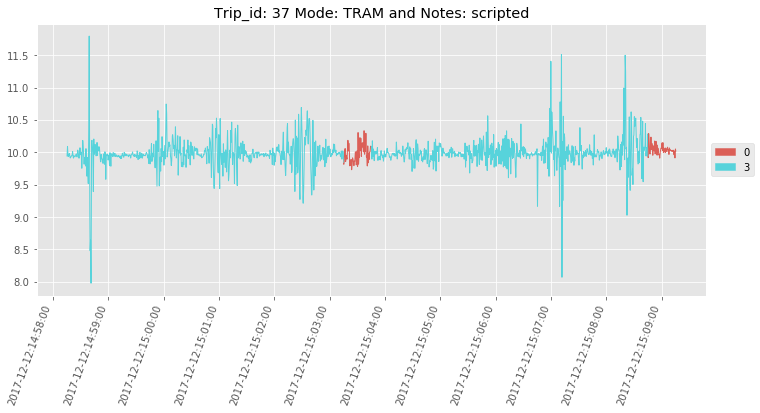

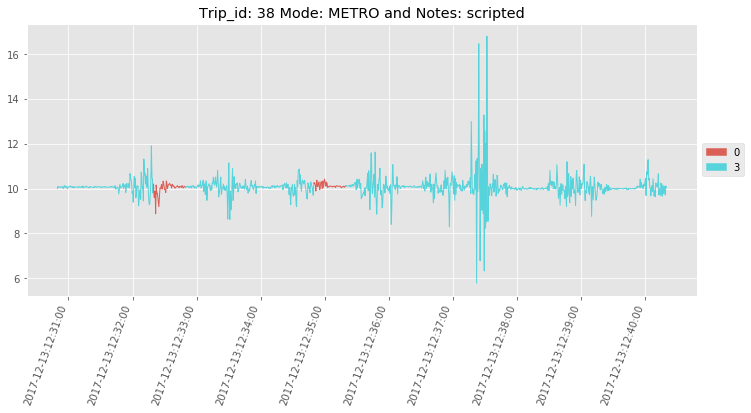

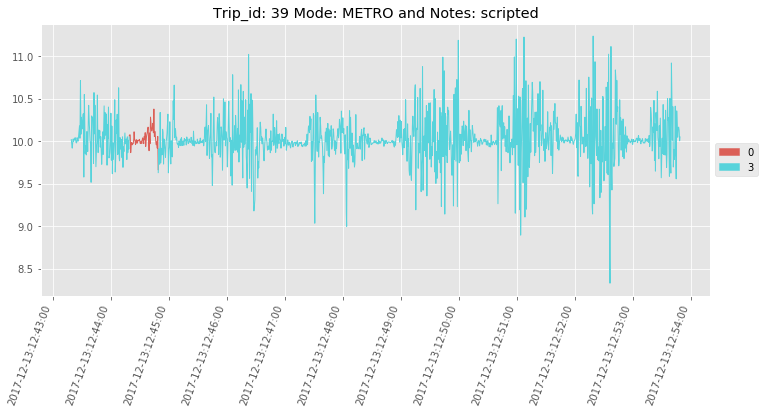

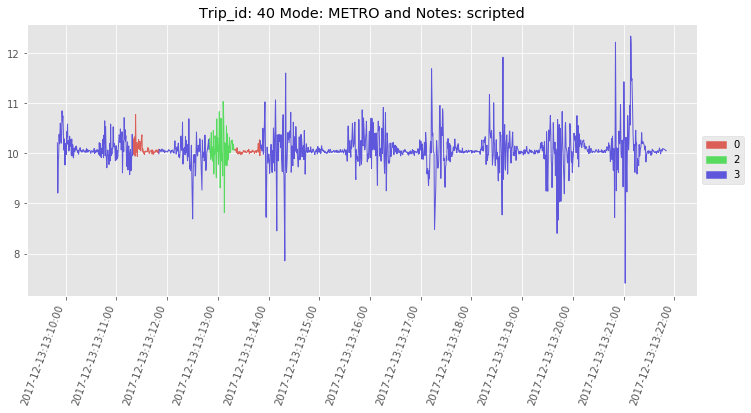

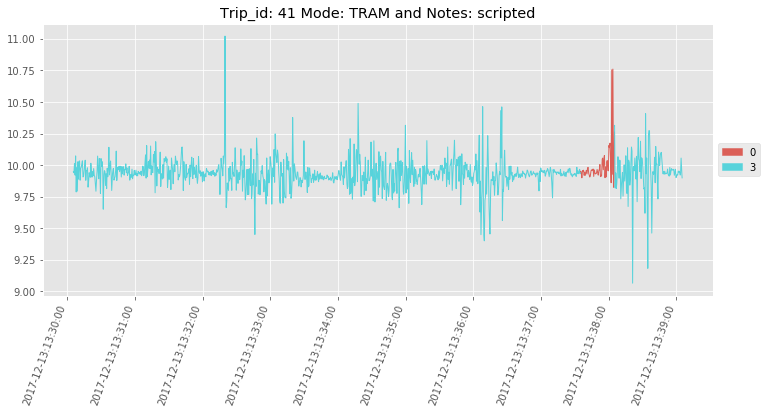

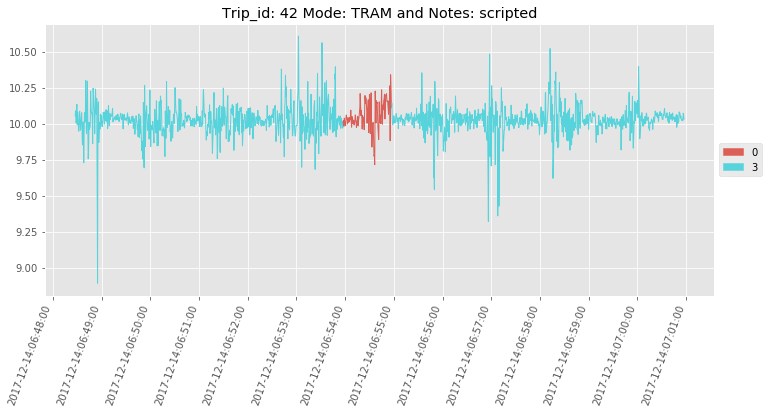

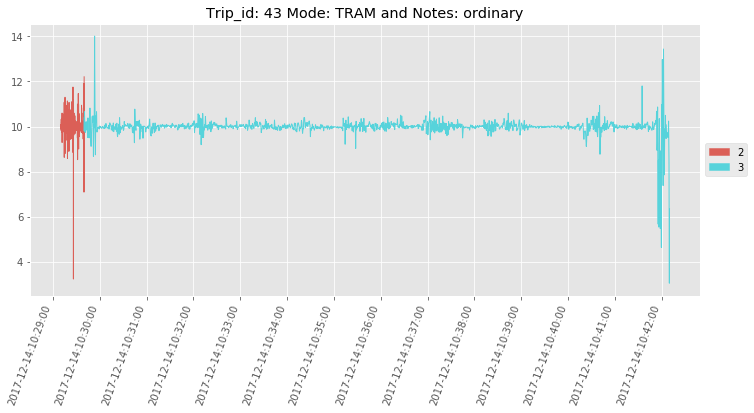

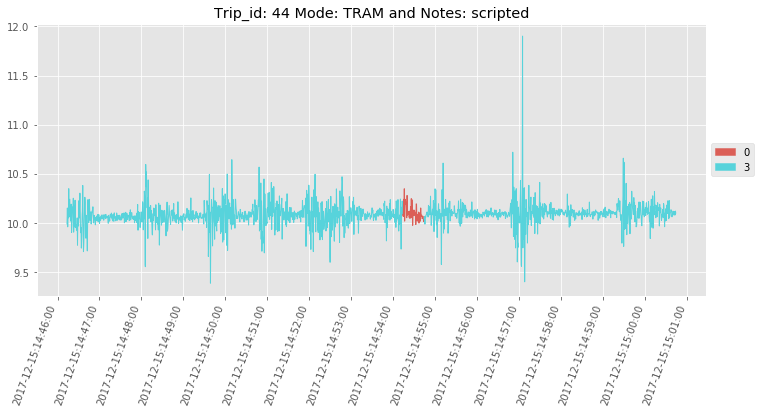

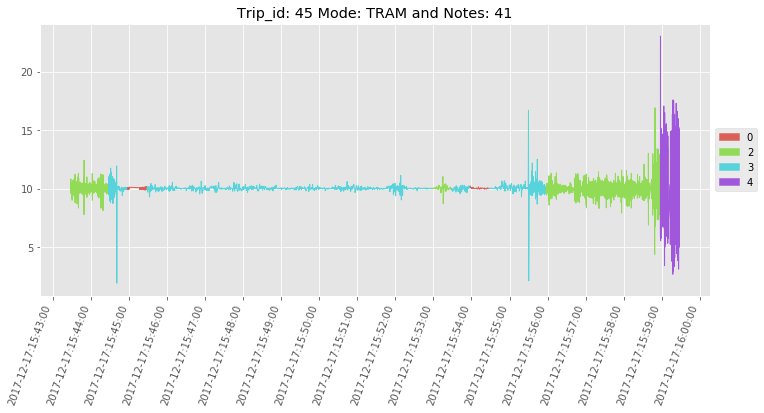

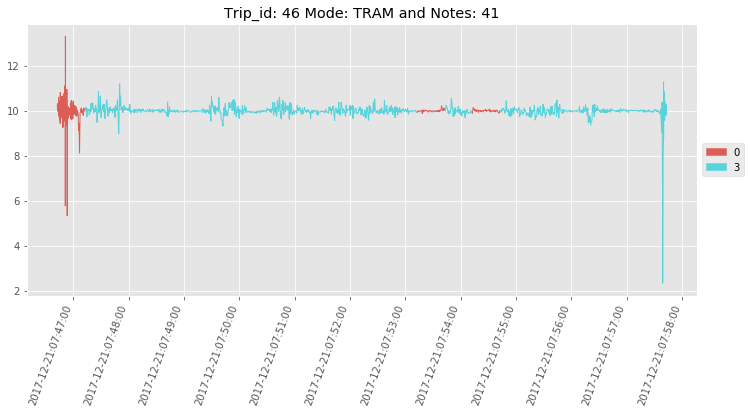

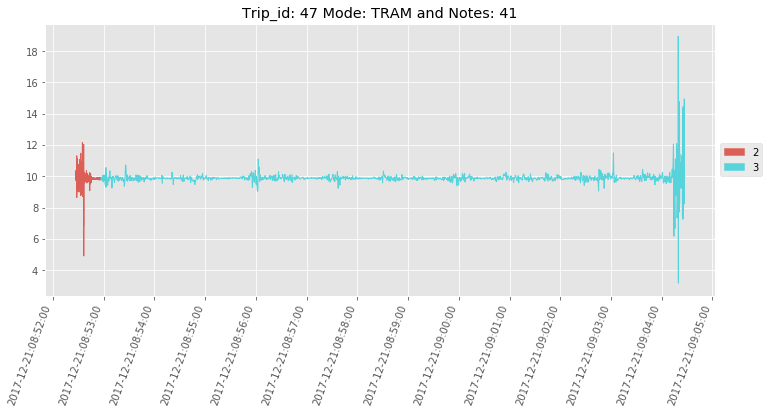

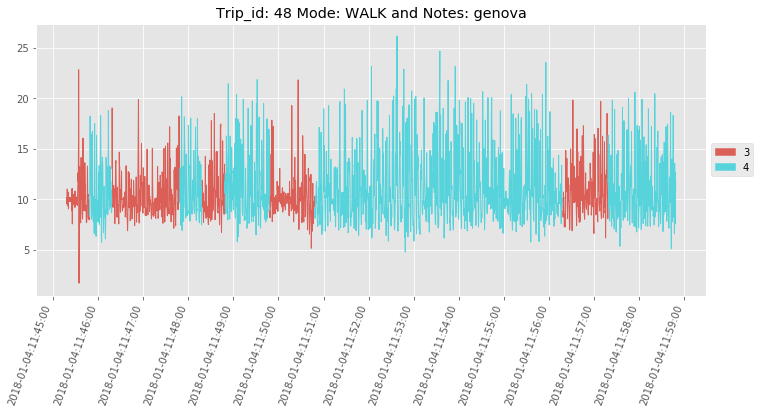

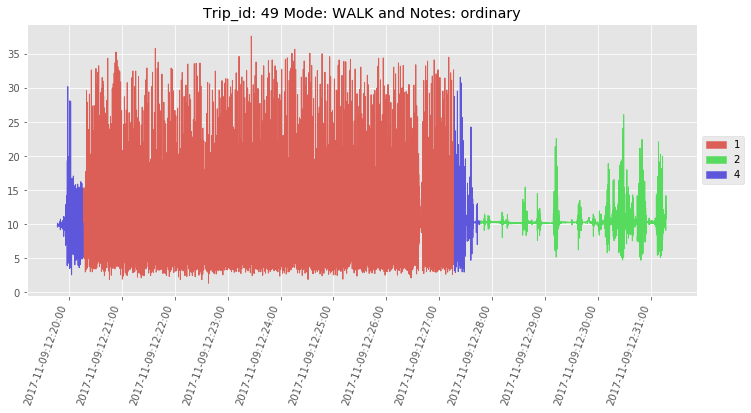

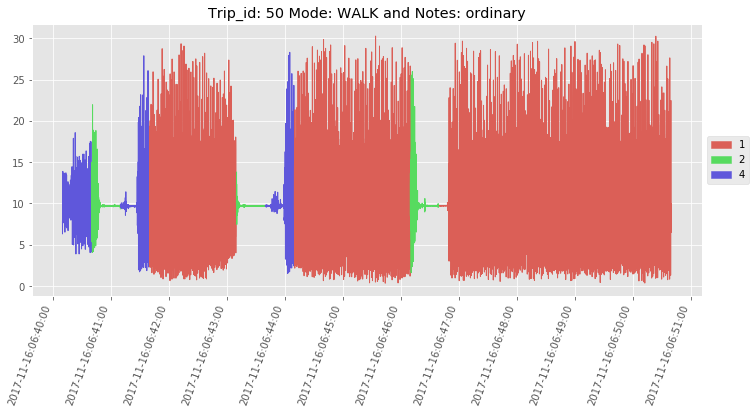

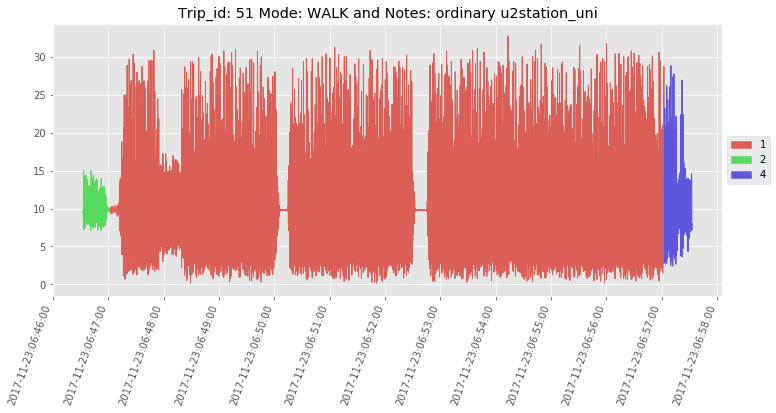

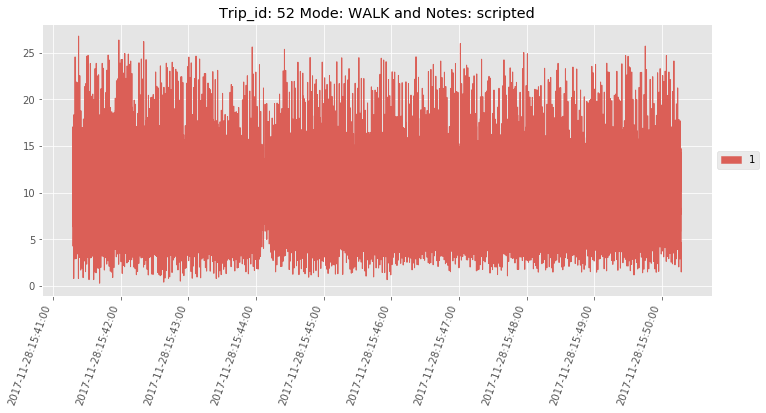

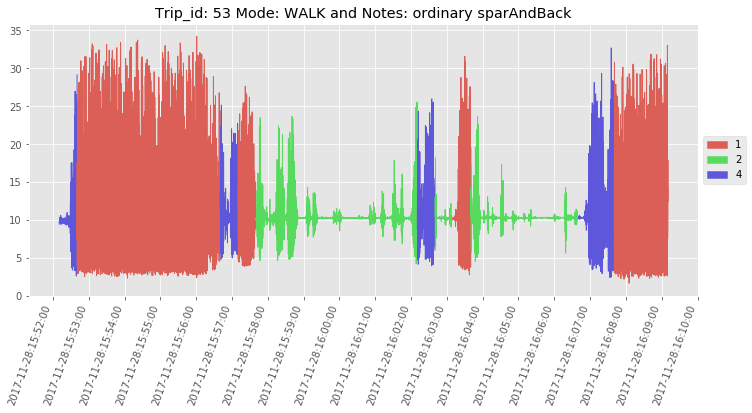

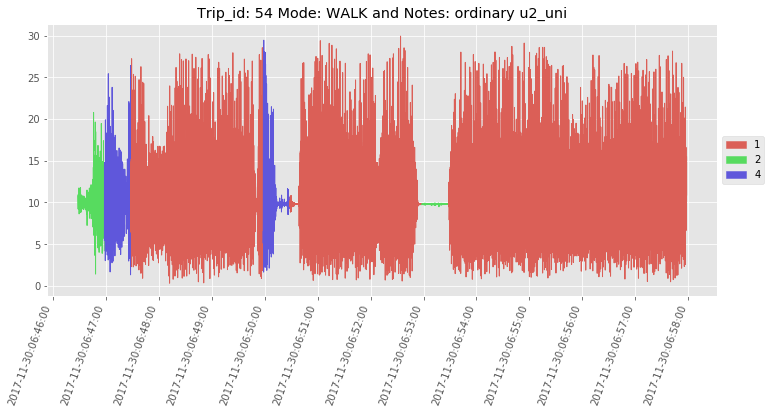

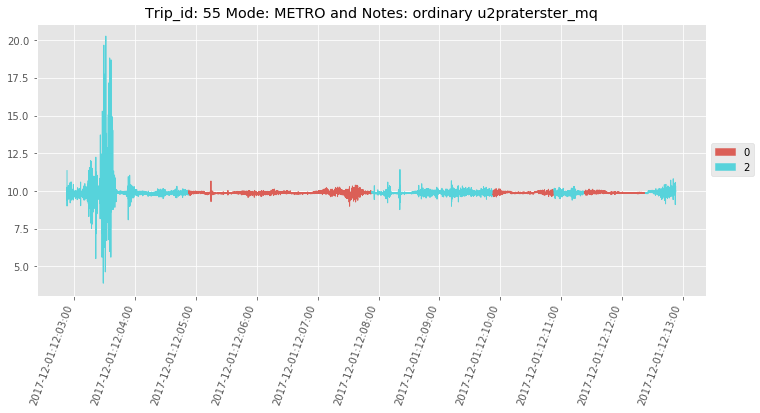

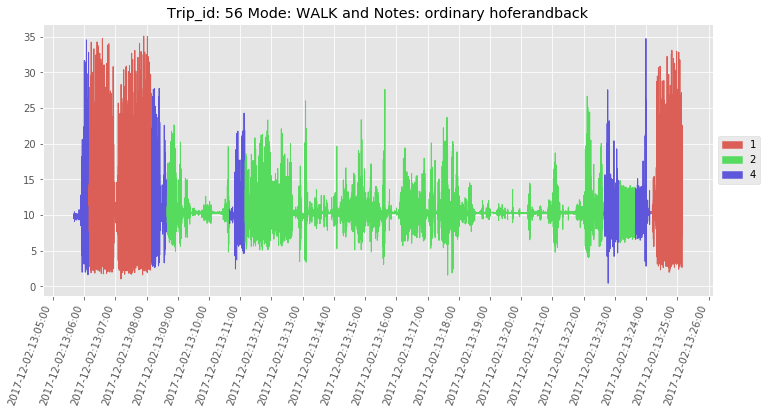

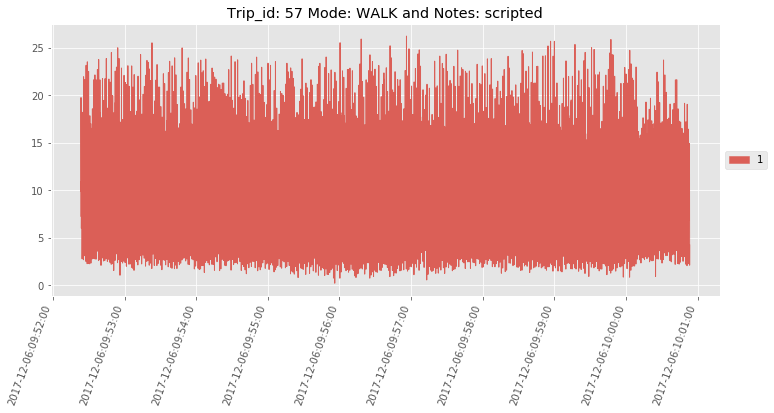

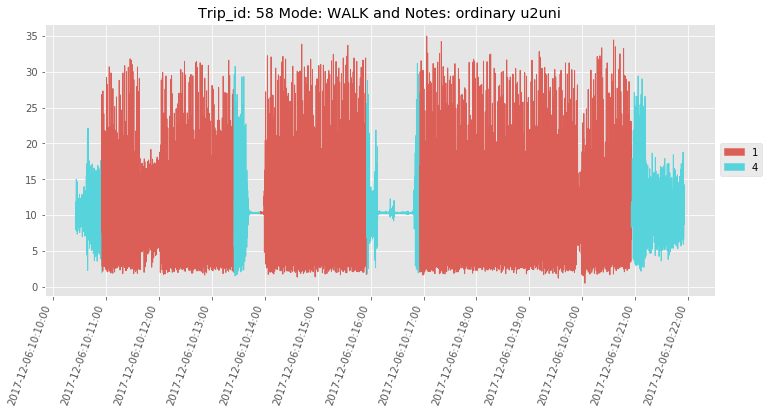

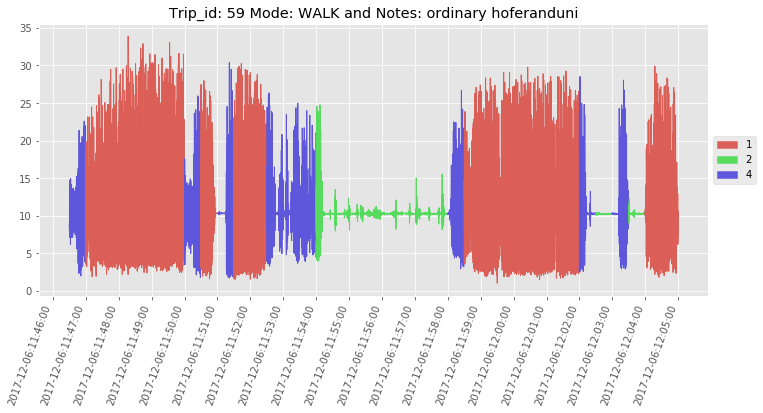

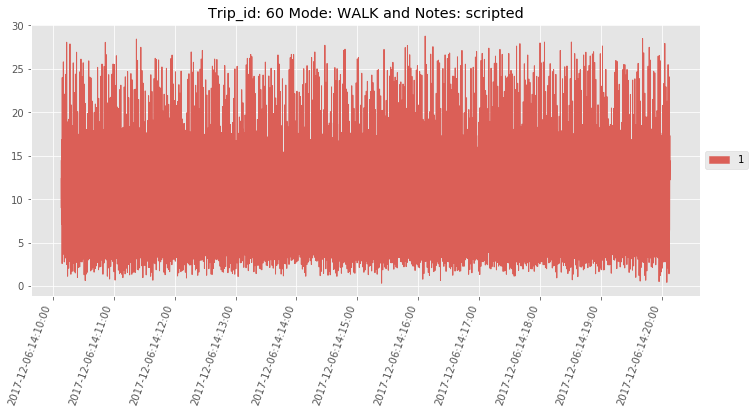

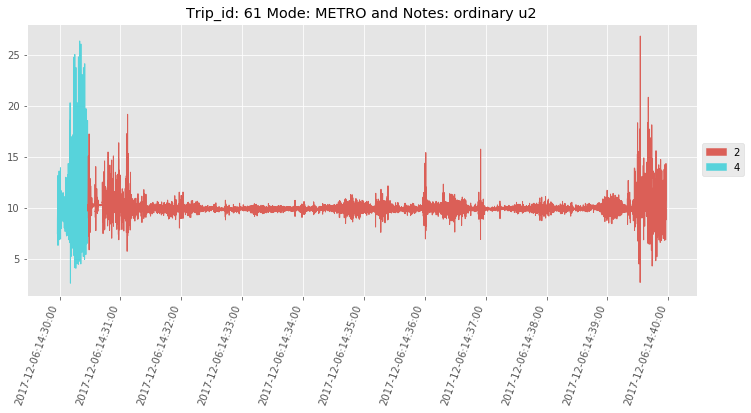

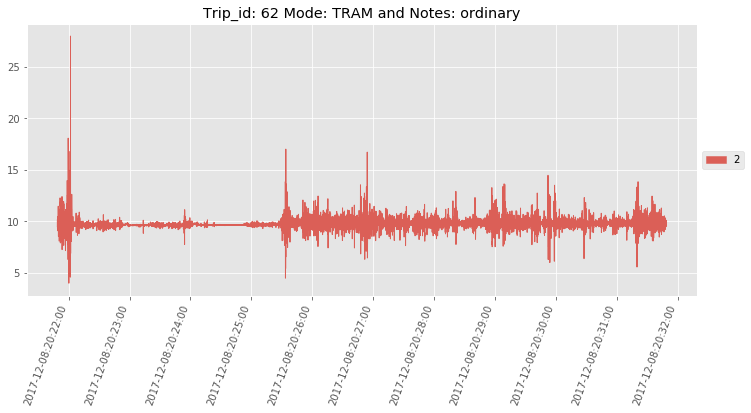

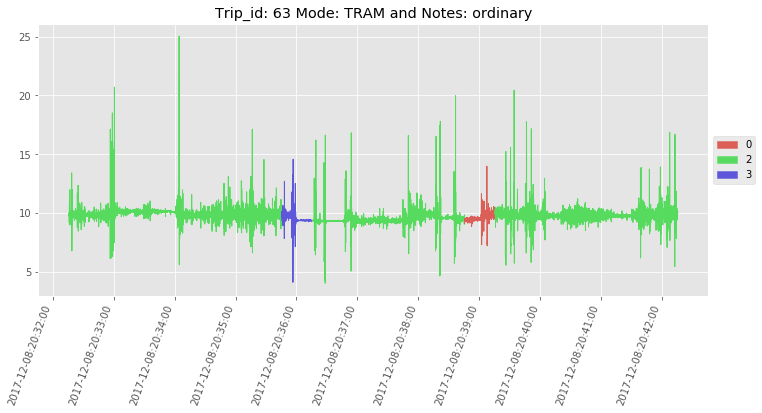

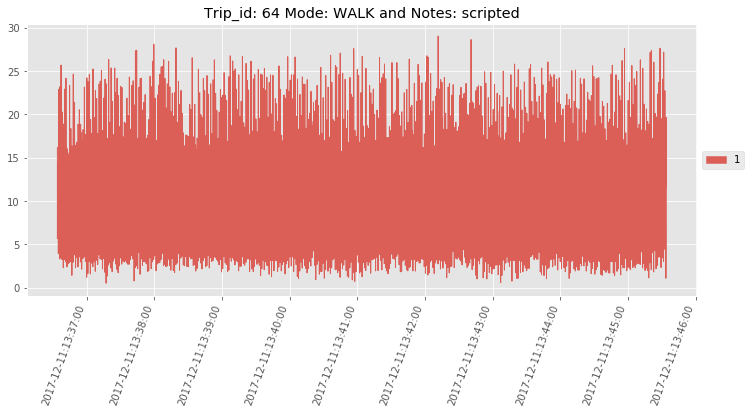

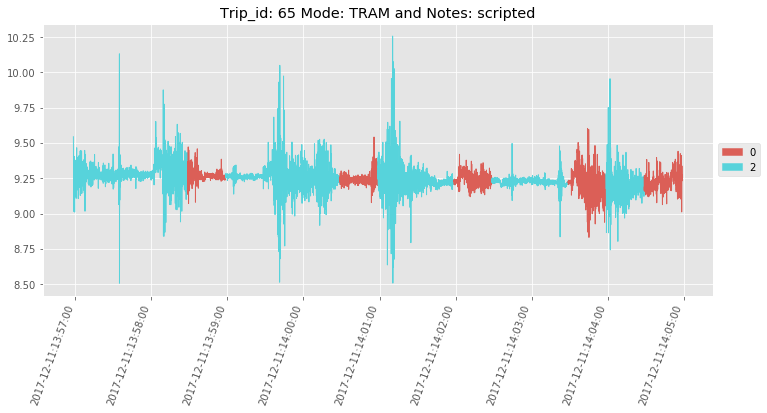

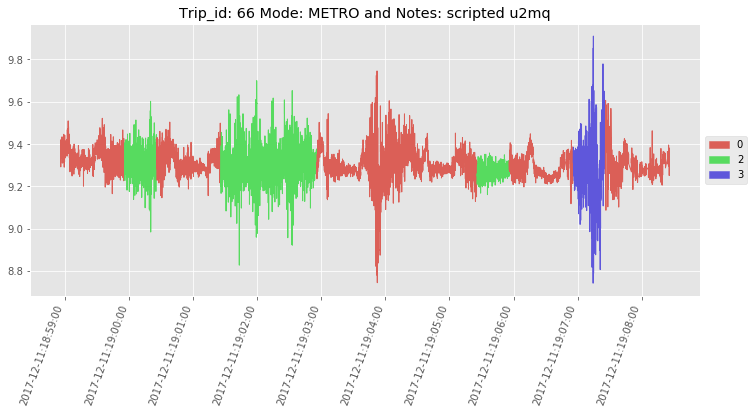

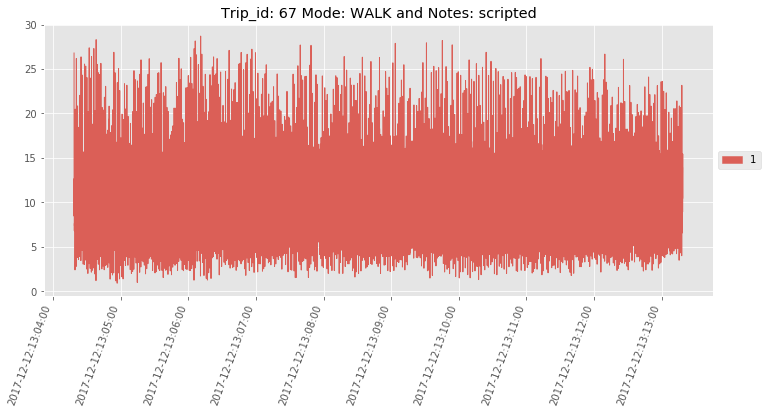

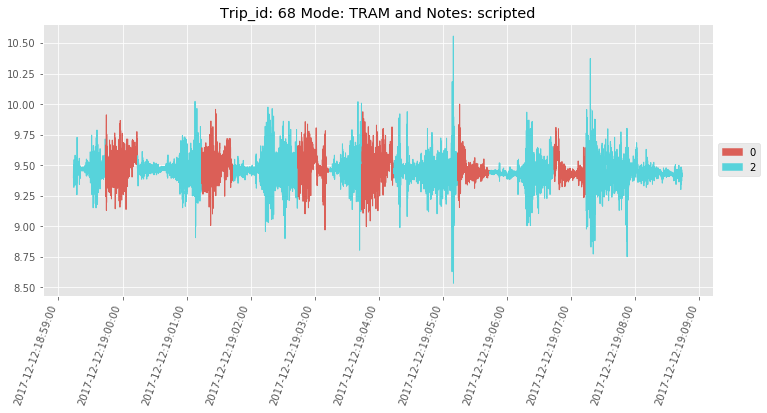

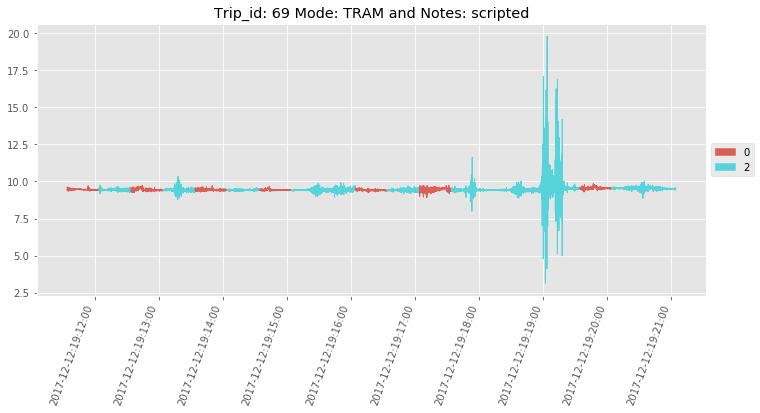

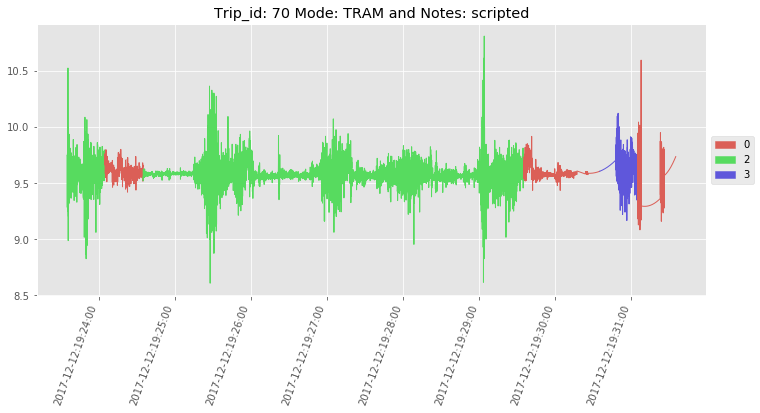

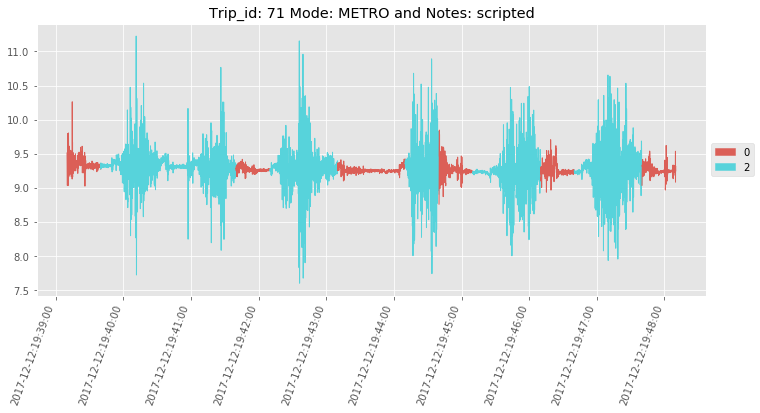

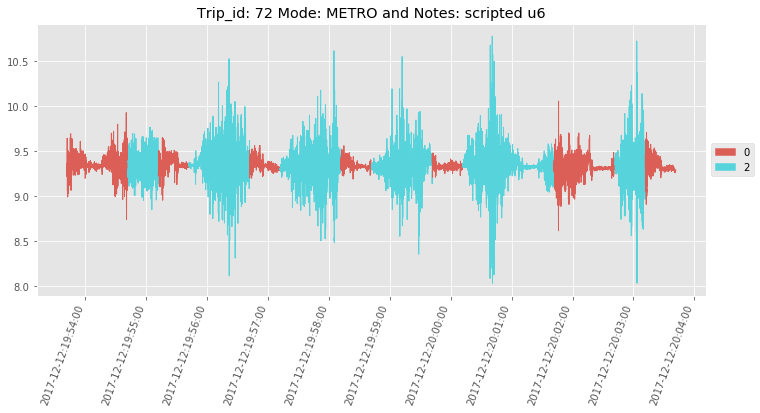

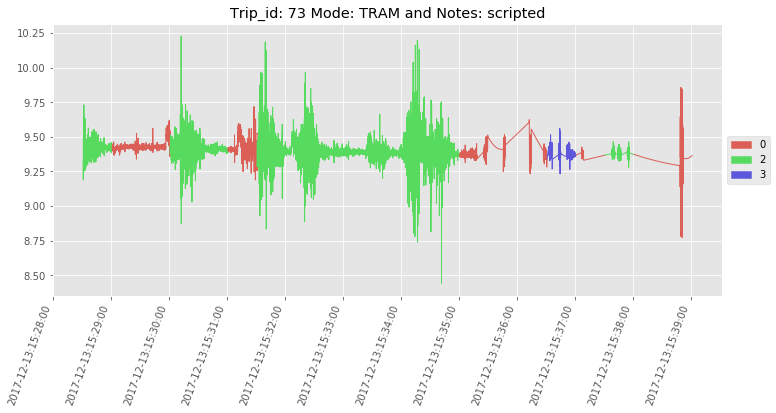

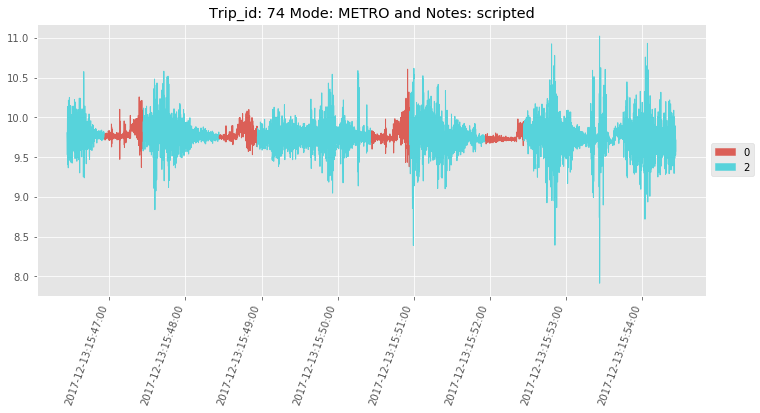

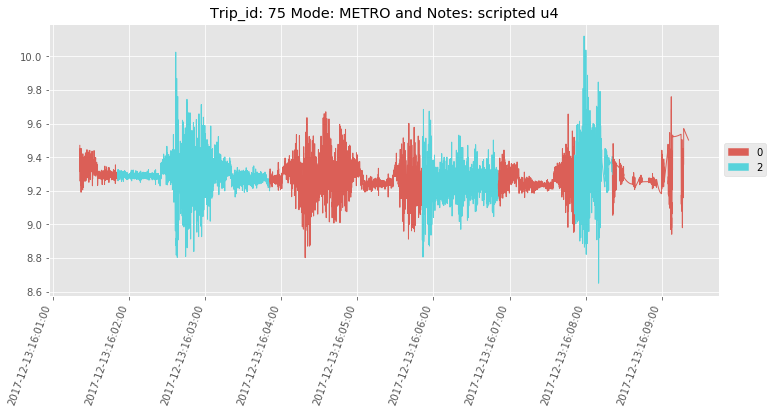

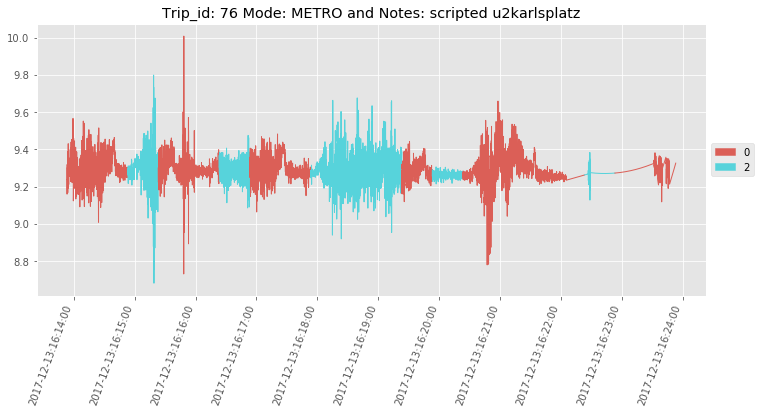

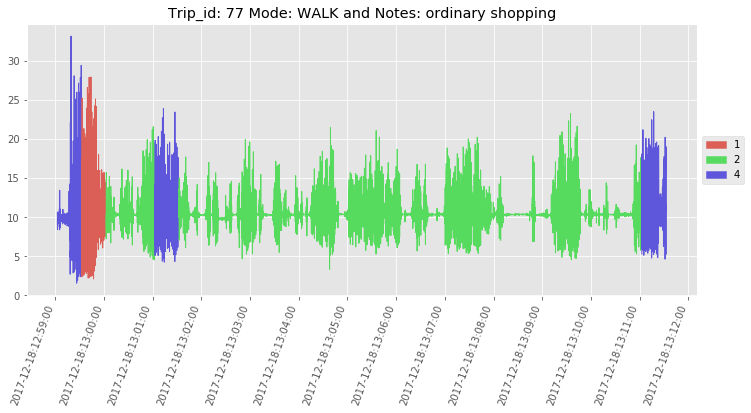

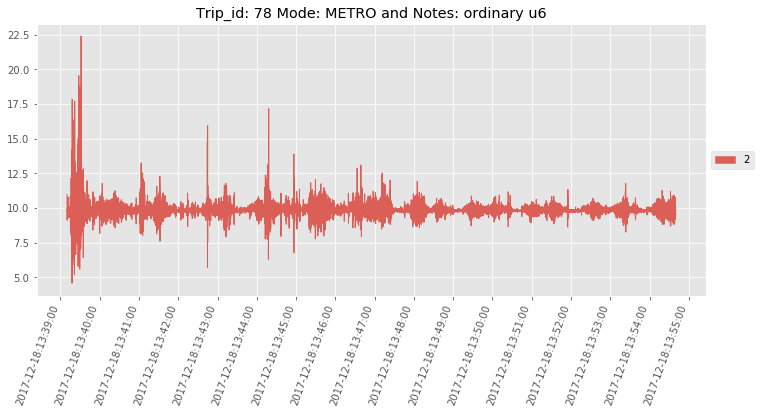

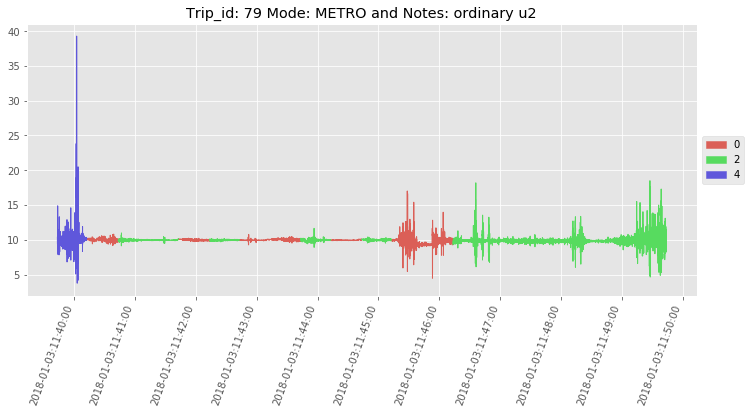

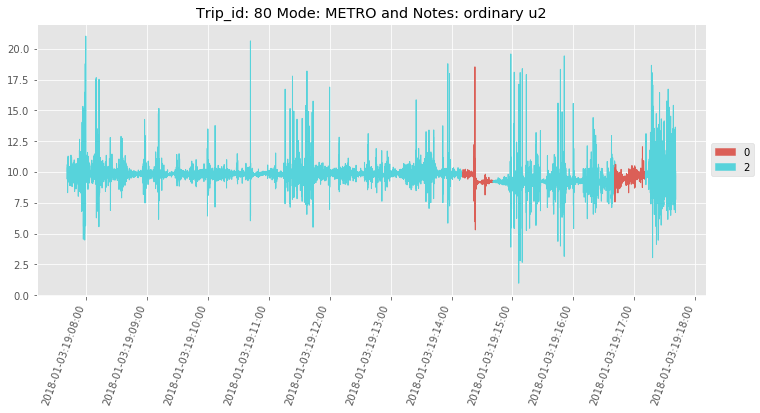

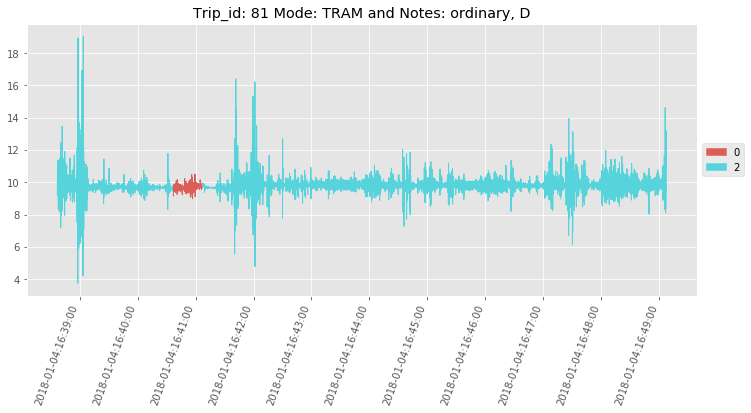

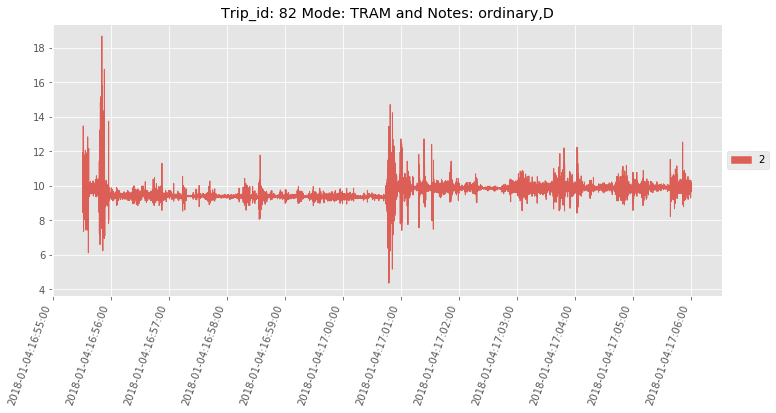

In [79]:
if plot_all_trips:
    trips_unpacked = Preprocessor.unpack_all_trips(dfs)
    plot_all_trips_with_cluster_coloring(trips_unpacked, euclidean_distances)
